# Vanilla auto encoder for feture extraction

### Attepmt to train the AutoEncoder (AE) as a feture extractor and improve for better classification 

**Overview** 
1. Undersample the class 8 to concner the inbalanced dataset
2. Train AutoEncoder with 7.5k training data with out label (Self-supervised)
3. Train liner classifier with 1.3k of training data with label (Which was not used in the AutoEncoder Training)
4. Validate trained liner classifier with 500 validation data

## GPUs information

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Nov 15 11:19:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Install required libraly

In [ ]:
!pip install -q tfds-nightly tensorflow-datasets tensorflow matplotlib

     |████████████████████████████████| 4.0 MB 4.1 MB/s 


In [ ]:
import tensorflow as tf
import cv2
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from scipy import misc

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses, models
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, BatchNormalization,Flatten, Reshape
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [ ]:
ds = tfds.load('deep_weeds', batch_size = -1, as_supervised = True)

images, labels = ds['train']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/17509 [00:00<?, ? examples/s]

Shuffling deep_weeds-train.tfrecord...:   0%|          | 0/17509 [00:00<?, ? examples/s]

Dataset deep_weeds downloaded and prepared to /root/tensorflow_datasets/deep_weeds/3.0.0. Subsequent calls will reuse this data.


## Undersample class 8 to avoid overfitting 

In [ ]:
train_X = images[:14000]
train_y = labels[:14000]


test_X = images[14000:]
test_y = labels[14000:]

In [ ]:
def re_size(img, new_size):
    return cv2.resize(img, new_size)

In [ ]:
X_train = []
Y_train = []

X_test = []
Y_test = []


for each_x, each_y in zip(train_X, train_y):
    X_train.append(re_size(each_x.numpy(), (128, 128)))
    Y_train.append(each_y)

for each_x, each_y in zip(test_X, test_y):
    X_test.append(re_size(each_x.numpy(), (128, 128)))    
    Y_test.append(each_y)
    
X_train = np.array(X_train)
Y_train = np.array(Y_train)

X_test = np.array(X_test)
Y_test = np.array(Y_test)

(128, 128, 3)


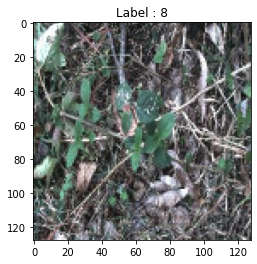

In [ ]:
i = 43
fig , ax = plt.subplots()
ax.imshow(X_train[i])
plt.title("Label : " + str(Y_test[i]))
print(X_train[0].shape)

In [ ]:
print("X train shape" + str(X_train.shape))
print("X test shape" + str(X_test.shape))

X train shape(14000, 128, 128, 3)
X test shape(3509, 128, 128, 3)


## Buliding the autoencoder

In [ ]:
code_size = 1024

# Encoder---
input_layer = Input(shape=(128, 128, 3), name="INPUT")

x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
#Latent space (Comressed fetures)
code_layer = Dense(code_size, name="CODE")(x)

# Decoder---
x = Dense(4096)(code_layer)
x = Reshape((16, 16, 16))(x)
x = Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)

output_layer = Conv2D(3, (3, 3), padding='same', name="OUTPUT")(x)

In [ ]:
weed_autoEncoder = Model(input_layer, output_layer)
weed_autoEncoder.compile(optimizer='adam', loss='mse')
weed_autoEncoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 INPUT (InputLayer)          [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 16)        4624  

## Train the decocder

In [ ]:
weed_autoEncoder.fit(X_train, X_train,
                epochs=20,
                batch_size=32,
                shuffle=True,
                validation_data=(X_test, X_test))

Epoch 1/20
438/438 [==============================] - 30s 31ms/step - loss: 2025.3390 - val_loss: 1648.6443
Epoch 2/20
438/438 [==============================] - 13s 29ms/step - loss: 1576.4280 - val_loss: 1520.6876
Epoch 3/20
438/438 [==============================] - 13s 29ms/step - loss: 1480.6245 - val_loss: 1457.6182
Epoch 4/20
438/438 [==============================] - 13s 29ms/step - loss: 1426.8508 - val_loss: 1402.8129
Epoch 5/20
438/438 [==============================] - 13s 29ms/step - loss: 1382.9565 - val_loss: 1432.6692
Epoch 6/20
438/438 [==============================] - 13s 29ms/step - loss: 1713.0236 - val_loss: 1393.3285
Epoch 7/20
438/438 [==============================] - 13s 29ms/step - loss: 1364.6869 - val_loss: 1358.5809
Epoch 8/20
438/438 [==============================] - 13s 29ms/step - loss: 1339.8522 - val_loss: 1345.0760
Epoch 9/20
438/438 [==============================] - 13s 29ms/step - loss: 1323.3483 - val_loss: 1333.7002
Epoch 10/20
438/438 [=======

##Show encoded image

In [ ]:
from tensorflow.keras.preprocessing import image

In [ ]:
weed_Encoder = Model(inputs=weed_autoEncoder.input, outputs=weed_autoEncoder.get_layer("CODE").output)

In [ ]:
encoded_weed_train = weed_Encoder.predict(X_train)

In [ ]:
#encoded_weed_train = encoded_weed_train.reshape((len(X_train), 32*32*8))
encoded_weed_train.shape

(14000, 1024)

In [ ]:
encoded_weed_test = weed_Encoder.predict(X_test)
#encoded_weed_test = encoded_weed_test.reshape((len(X_test), 32*32*8))
encoded_weed_test.shape

(3509, 1024)

In [ ]:
reconstructed_weed = weed_autoEncoder.predict(X_test[:10])

In [ ]:
def show_data(X, n=10, height=28, width=28, title=""):
    plt.figure(figsize=(10, 3))
    for i in range(n):
        ax = plt.subplot(2,n,i+1)
        plt.imshow(X[i].reshape((height,width)))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.suptitle(title, fontsize = 20)

In [ ]:
def show_cat_data(X, n=10, title=""):
    plt.figure(figsize=(15, 5))
    for i in range(n):
        ax = plt.subplot(2,n,i+1)
        plt.imshow(image.array_to_img(X[i]))
        plt.title("Label" + str(Y_test[i]))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.suptitle(title, fontsize = 20)

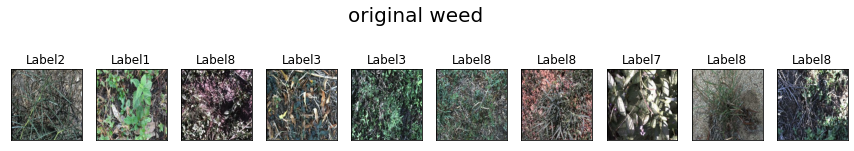

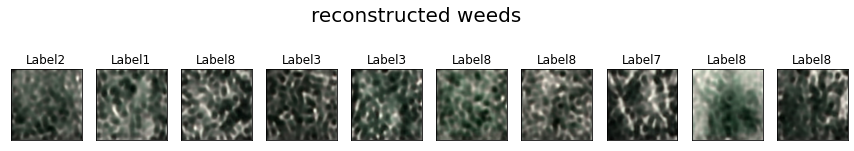

In [ ]:
show_cat_data(X_test, title="original weed")
#show_data(encoded_weed_test, height=20, width=50, title="encoded weed (latent space representation)")
show_cat_data(reconstructed_weed, title="reconstructed weeds")

## Train linner model for classificatoin

In [ ]:
X_train_new = weed_Encoder.predict(X_train)
X_test_new = weed_Encoder.predict(X_test)

y_train_new = train_y
y_test_new = test_y

print(X_train_new.shape)
print(y_train_new.shape)

print(X_test_new.shape)
print(y_test_new.shape)

(14000, 1024)
(14000,)
(3509, 1024)
(3509,)


### SVM

In [ ]:
from sklearn import  svm

new_clf = svm.SVC(gamma="scale")
svm_model = new_clf.fit(X_train_new, y_train_new)
print('svm accuracy for training set: %f' % svm_model.score(X_train_new, y_train_new))
print('svm accuracy for test set: %f' % svm_model.score(X_test_new, y_test_new))

svm accuracy for training set: 0.537000
svm accuracy for test set: 0.513822


In [ ]:
from sklearn.metrics import classification_report

y_pred = svm_model.predict(X_test_new)

print(classification_report(y_test_new, y_pred))

              precision    recall  f1-score   support

           0       0.33      0.00      0.01       217
           1       0.00      0.00      0.00       206
           2       0.00      0.00      0.00       219
           3       0.00      0.00      0.00       196
           4       0.00      0.00      0.00       208
           5       0.00      0.00      0.00       212
           6       0.00      0.00      0.00       226
           7       0.33      0.00      0.01       223
           8       0.51      1.00      0.68      1802

    accuracy                           0.51      3509
   macro avg       0.13      0.11      0.08      3509
weighted avg       0.31      0.51      0.35      3509



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### KNN

In [ ]:
from sklearn import neighbors

knn = neighbors.KNeighborsClassifier(n_neighbors = 3, metric='euclidean')
knn_model = knn.fit(X_train_new, y_train_new)
print('kNN accuracy for training set: %f' % knn_model.score(X_train_new, y_train_new))
print('kNN accuracy for test set: %f' % knn_model.score(X_test_new, y_test_new))

kNN accuracy for training set: 0.611786
kNN accuracy for test set: 0.474209


In [ ]:
y_pred = knn_model.predict(X_test_new)

print(classification_report(y_test_new, y_pred))

              precision    recall  f1-score   support

           0       0.24      0.09      0.13       217
           1       0.00      0.00      0.00       206
           2       0.07      0.12      0.09       219
           3       0.21      0.03      0.05       196
           4       0.08      0.02      0.04       208
           5       0.00      0.00      0.00       212
           6       0.11      0.02      0.03       226
           7       0.30      0.03      0.05       223
           8       0.55      0.89      0.68      1802

    accuracy                           0.47      3509
   macro avg       0.17      0.13      0.12      3509
weighted avg       0.35      0.47      0.37      3509



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### ramdom RandomForest 

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=0)
rf_model = rf.fit(X_train_new, y_train_new)
print('RandomForest accuracy for training set: %f' % rf_model.score(X_train_new, y_train_new))
print('RandomForest accuracy for test set: %f' % rf_model.score(X_test_new, y_test_new))

RandomForest accuracy for training set: 1.000000
RandomForest accuracy for test set: 0.527216


In [ ]:
y_pred = rf_model.predict(X_test_new)

print(classification_report(y_test_new, y_pred))

              precision    recall  f1-score   support

           0       0.32      0.15      0.21       217
           1       0.00      0.00      0.00       206
           2       0.36      0.02      0.03       219
           3       0.40      0.02      0.04       196
           4       0.24      0.03      0.06       208
           5       1.00      0.00      0.01       212
           6       0.86      0.03      0.05       226
           7       0.40      0.14      0.21       223
           8       0.54      0.98      0.70      1802

    accuracy                           0.53      3509
   macro avg       0.46      0.15      0.14      3509
weighted avg       0.50      0.53      0.39      3509



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Logistic regresion

In [ ]:
from sklearn.linear_model import LogisticRegression


lr = LogisticRegression(penalty='none', 
                         tol=0.1, solver='saga',
                         multi_class='multinomial')
lr_model = lr.fit(X_train_new, y_train_new)
print('LogisticRegression accuracy for training set: %f' % lr_model.score(X_train_new, y_train_new))
print('LogisticRegression accuracy for test set: %f' % lr_model.score(X_test_new, y_test_new))

LogisticRegression accuracy for training set: 0.555000
LogisticRegression accuracy for test set: 0.501852


In [ ]:
y_pred = lr_model.predict(X_test_new)

print(classification_report(y_test_new, y_pred))

              precision    recall  f1-score   support

           0       0.23      0.18      0.20       217
           1       0.19      0.10      0.13       206
           2       0.29      0.03      0.06       219
           3       0.11      0.02      0.03       196
           4       0.03      0.00      0.01       208
           5       0.00      0.00      0.00       212
           6       0.20      0.01      0.02       226
           7       0.35      0.15      0.21       223
           8       0.55      0.92      0.69      1802

    accuracy                           0.50      3509
   macro avg       0.22      0.16      0.15      3509
weighted avg       0.37      0.50      0.39      3509



## Fully connected layer 

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(248, activation='relu'),
    tf.keras.layers.Dense(248, activation='relu'),
    tf.keras.layers.Dense(9,  activation='softmax')
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.fit(X_train_new, y_train_new, epochs=10)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


438/438 [==============================] - 1s 2ms/step - loss: 3.8616 - accuracy: 0.4249
Epoch 2/10
438/438 [==============================] - 1s 2ms/step - loss: 1.5104 - accuracy: 0.5385
Epoch 3/10
438/438 [==============================] - 1s 2ms/step - loss: 1.3125 - accuracy: 0.5866
Epoch 4/10
438/438 [==============================] - 1s 2ms/step - loss: 1.1637 - accuracy: 0.6196
Epoch 5/10
438/438 [==============================] - 1s 2ms/step - loss: 1.0878 - accuracy: 0.6471
Epoch 6/10
438/438 [==============================] - 1s 2ms/step - loss: 1.0173 - accuracy: 0.6667
Epoch 7/10
438/438 [==============================] - 1s 2ms/step - loss: 0.9332 - accuracy: 0.6921
Epoch 8/10
438/438 [==============================] - 1s 2ms/step - loss: 0.8413 - accuracy: 0.7199
Epoch 9/10
438/438 [==============================] - 1s 2ms/step - loss: 0.7209 - accuracy: 0.7591
Epoch 10/10
438/438 [==============================] - 1s 2ms/step - loss: 0.6699 - accuracy: 0.7764


In [ ]:
test_loss, test_acc = model.evaluate(X_test_new,  y_test_new, verbose=2)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


110/110 - 0s - loss: 3.0211 - accuracy: 0.4466 - 249ms/epoch - 2ms/step


In [ ]:
y_pred = model.predict(X_test_new)

y_pred = np.argmax(y_pred, axis=1) # Convert one-hot to index

In [ ]:
from sklearn.metrics import classification_report

print(y_pred)
print(classification_report(test_y, y_pred))

[8 8 5 ... 8 8 8]
              precision    recall  f1-score   support

           0       0.16      0.10      0.12       217
           1       0.16      0.21      0.18       206
           2       0.17      0.05      0.08       219
           3       0.15      0.08      0.11       196
           4       0.09      0.06      0.07       208
           5       0.08      0.06      0.07       212
           6       0.20      0.06      0.09       226
           7       0.23      0.09      0.13       223
           8       0.57      0.79      0.66      1802

    accuracy                           0.45      3509
   macro avg       0.20      0.17      0.17      3509
weighted avg       0.37      0.45      0.39      3509

